In [1]:
from scipy.signal import spectrogram, resample
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np

(1818752,)
44100


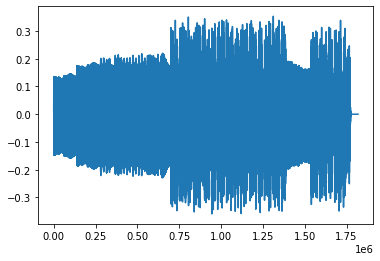

In [2]:
# Read file

audio, rate = sf.read("Samples/337653__hmmm101__pixel-song-19.wav")

print(audio.shape)
plt.plot(audio)
print(rate)

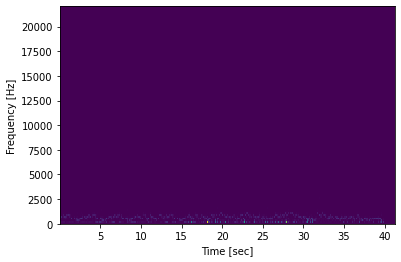

In [3]:
f, t, Sxx = spectrogram(audio, rate)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [4]:
def to_mono(audio):
    if len(audio.shape) < 2:
        # already mono
        return audio
    num_channels = audio.shape[1]
    if num_channels > 2:
        # because I'm not sure how to deal with 5.1 etc
        raise Exception("Can only deal with stereo or mono input")
    return (audio[:, 0] + audio[:, 1]) / 2

def graph_audio(filename):
    audio, rate = sf.read(filename)
    print(f"{rate}Hz")
    audio = to_mono(audio)
    plt.plot(audio)
    plt.show()
    f, t, Sxx = spectrogram(audio, rate)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    return f, t, Sxx

44100Hz


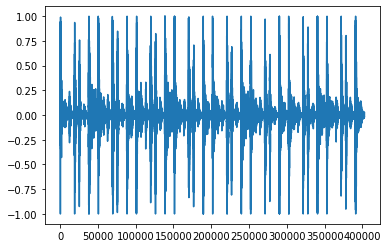

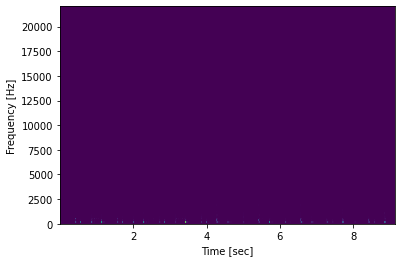

In [5]:
rumba_f = "/home/cameron/src/abracadabra/Samples/337443__nemaavla__greek-rumba.wav"
f, t, Sxx = graph_audio(rumba_f)

f: (129,)
t: (1797,)
Sxx: (129, 1797)
[[1.31115635e-06 4.67891359e-06 1.42058059e-05]
 [5.08625219e-04 2.23133178e-03 1.57886409e-03]
 [2.40281496e-05 9.68776500e-05 1.62512364e-04]
 [7.10148438e-07 7.36073291e-06 5.41088529e-05]
 [2.80069830e-06 1.44887630e-07 9.51127905e-06]
 [6.46889791e-07 1.11231252e-06 3.89169115e-06]
 [1.80576201e-06 4.41622091e-06 5.39140573e-06]
 [7.15994322e-06 3.67990190e-06 7.42097553e-06]
 [1.16386667e-07 1.10613358e-06 5.51872824e-06]
 [3.11962887e-07 3.57456553e-06 5.70679737e-07]
 [2.82648708e-06 4.76066207e-07 6.32169155e-07]
 [1.16847006e-06 7.85803794e-07 7.90888125e-09]
 [1.73220580e-06 3.04231498e-07 2.89298116e-08]
 [1.22604302e-06 6.15341995e-07 1.14429666e-07]
 [4.06536548e-07 1.39315041e-07 1.14960158e-07]
 [1.09396494e-06 5.84613896e-08 3.68214026e-07]
 [1.84192891e-06 2.41595618e-07 1.41749431e-07]
 [1.96598038e-08 6.60842302e-08 1.10914813e-07]
 [5.11813972e-07 3.47797118e-08 2.07447158e-07]
 [5.79770520e-07 1.31169207e-08 2.93580305e-08]
 [

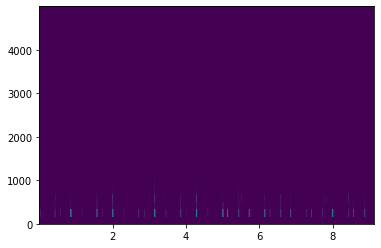

In [6]:
# This is me being concerned by the amount of purple in the above image
print(f"f: {f.shape}\nt: {t.shape}\nSxx: {Sxx.shape}")

f_cut = f[:30]
Sxx_cut = Sxx[:30, :]

plt.pcolormesh(t, f_cut, Sxx_cut)

print(Sxx_cut[:, :3])

Time to turn the spectrogram into a constellation map.

Need to pick the peaks in the spectrogram but space them using some density variable. I think this density variable could be the side length of a square. The spectrogram could then be split into a grid of these component squares and the peak from each of these squares picked. If this doesn't work, then maybe a (time, freq) tuple could define a rectangle to be used in the same way.

In the paper, they only use frequencies up to 4000Hz. From a quick Google search, that sounds reasonable. https://www.psbspeakers.com/the-frequencies-of-music/ 5KHz covers most of the range of instruments.

So, steps:
 - Cut spectrogam to 5KHz
 - Iterate through the "squares" in this spectrogram and find the peak in each one
 - Graph this constellation map
 
Questions:
 - Is it better to downsample the audio, or cut the spectrum?
   - My intuition is that it would be better to cut the spectrum since downsampling the audio could introduce aliasing. It might depend on how well I can control the number of FFT bins in the spectrogram.
   - Actually, it looks like downsampling is valid https://dsp.stackexchange.com/questions/30374/the-relationship-between-downsampling-and-frequency-resolution
 - What window should I use?
   - Tukey looks fine, but the nperseg parameter looks like it would increase my resolution. nperseg controls how many samples are used per time-sample

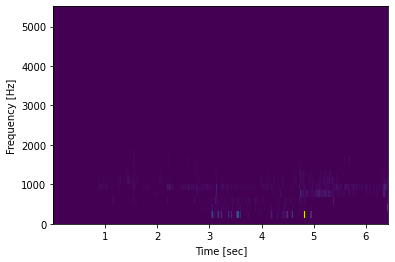

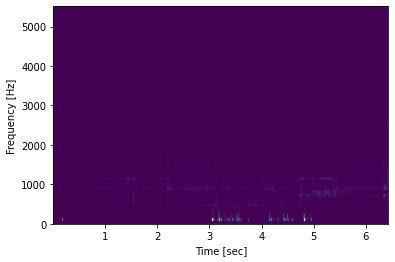

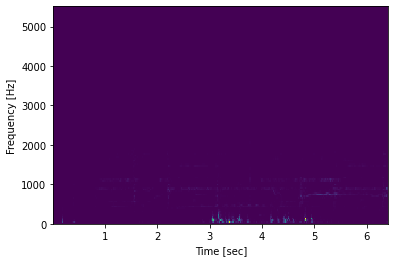

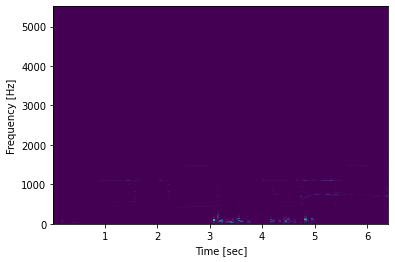

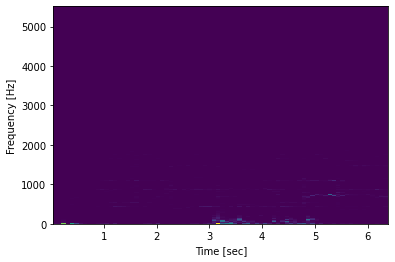

In [7]:
# Various nperseg values

test_muse = "/home/cameron/src/abracadabra/Samples/test.wav"

audio, rate = sf.read(test_muse)
audio = to_mono(audio)

new_rate = 11025
num_samples_required = int(audio.size / (rate / new_rate))

downsampled = resample(audio, num_samples_required)

# 256 is something like 23ms
n64   = spectrogram(downsampled, new_rate, nperseg=64)
# 128 feels right (~10ms)
n128  = spectrogram(downsampled, new_rate, nperseg=128)
n256  = spectrogram(downsampled, new_rate, nperseg=256)
n512  = spectrogram(downsampled, new_rate, nperseg=512)
n1024 = spectrogram(downsampled, new_rate, nperseg=1024)

def graph_spectrogram_result(f, t, Sxx, title=None):
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if title is not None:
        plt.title(title)
    plt.show()
    
graph_spectrogram_result(*n64)
graph_spectrogram_result(*n128)
graph_spectrogram_result(*n256)
graph_spectrogram_result(*n512)
graph_spectrogram_result(*n1024)

In [8]:
def downsample(audio, orig_rate, target_rate):
    num_samples_required = int(audio.size / (rate / new_rate))
    return resample(audio, num_samples_required)

def my_spectrogram(audio, sample_rate):
    # aim for 10ms segments (100 per second)
    nperseg = int(sample_rate / 100)
    return spectrogram(audio, sample_rate, nperseg=nperseg)

def file_to_spectrogram(filename):
    audio, rate = sf.read(filename)
    audio = downsample(to_mono(audio), rate, 11025)
    return my_spectrogram(audio, 11025)

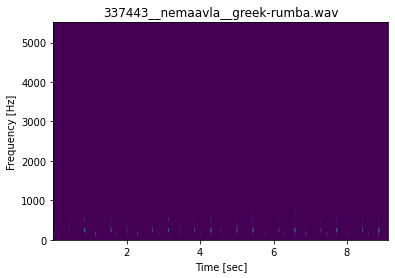

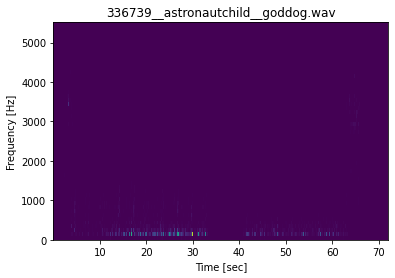

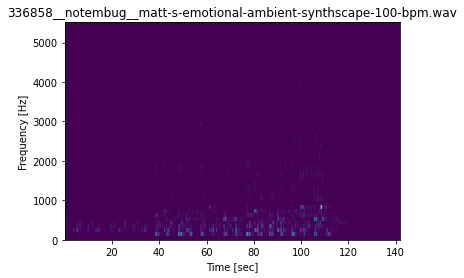

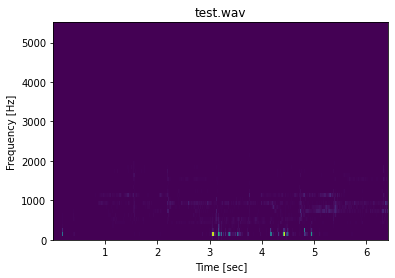

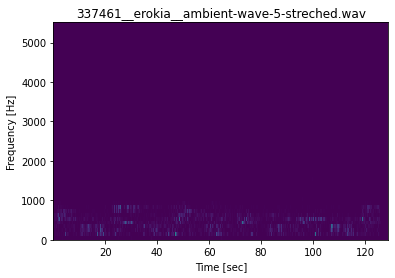

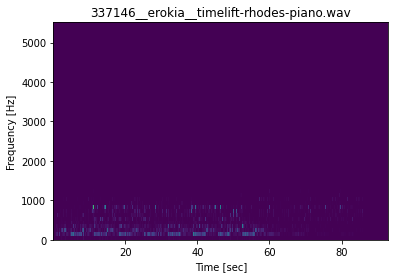

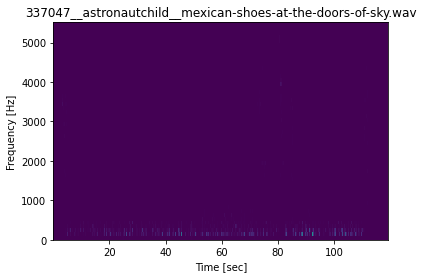

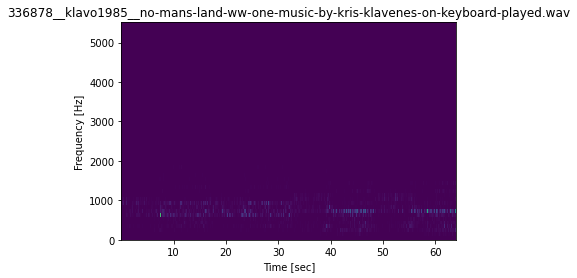

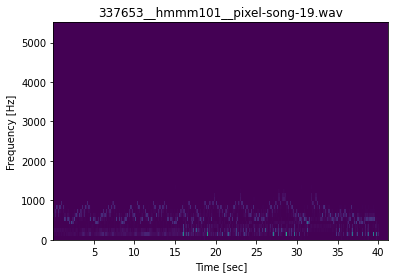

In [9]:
import os

for file in os.listdir('Samples'):
    if file.split('.')[-1] != 'wav':
        continue
    spec = file_to_spectrogram(f"Samples/{file}")
    graph_spectrogram_result(*spec, file)

In [10]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a.shape)

(2, 3)


In [11]:
def chunk_generator_2d(arr, x_size, y_size):
    for y in range(0, arr.shape[0], y_size):
        for x in range(0, arr.shape[1], x_size):
            yield arr[y:y+y_size, x:x+x_size], y, x

# test above
test_arr = np.array([np.arange(5), np.arange(5)])
for elem in chunk_generator_2d(test_arr, 2, 2):
    print(elem)
    
print(test_arr)

(array([[0, 1],
       [0, 1]]), 0, 0)
(array([[2, 3],
       [2, 3]]), 0, 2)
(array([[4],
       [4]]), 0, 4)
[[0 1 2 3 4]
 [0 1 2 3 4]]


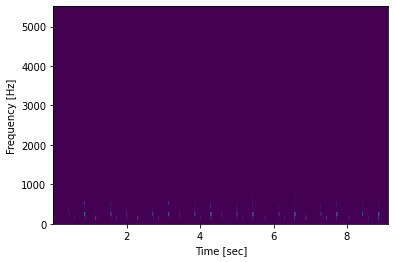

(56, 1037)


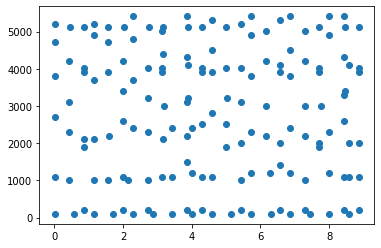

In [12]:
f, t, Sxx = file_to_spectrogram(rumba_f)

graph_spectrogram_result(f, t, Sxx)

print(Sxx.shape)

peaks_x = []
peaks_y = []

# spectrum, chunk width, chunk height
for chunk, y, x in chunk_generator_2d(Sxx, 40, 10):
    inds = np.unravel_index(np.argmax(chunk), chunk.shape)
    inds = [inds[0] + y, inds[1] + x]
    peaks_x.append(t[inds[1]])
    peaks_y.append(f[inds[0]])
    
plt.scatter(peaks_x, peaks_y)

I don't think the above is a correct way of finding the peaks because of the sentence

 > A  time-frequency  point  is  a  candidate  peak  if  it  has  a  higher  energy  content  than  all  its  neighbors  in  a  region  centered  around  the  point.
 
Maybe a search function would be more appropriate? Something like:
- Pick peak within `r` of upper-left corner of graph
- Then for every peak selected
  - Pick the peak between r and 2r away from that peak
  - Check it's not close to any existing peak
  - Remove it from consideration
- Until an iteration has no new peaks

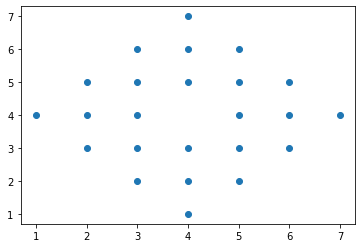

In [51]:
def neighbours_within(center, distance, shape):
    # using taxicab distance
    xs = []
    ys = []
    for x in range(-distance, distance+1):
        y_min = -(distance - abs(x))
        y_max = distance - abs(x)
        for y in range(y_min, y_max+1):
            if x == 0 and y == 0:
                continue
            new_x = center[1] + x
            new_y = center[0] + y
            if new_x < 0 or new_x >= shape[1]:
                continue
            if new_y < 0 or new_y >= shape[0]:
                continue
            ys.append(center[0] + y)
            xs.append(center[1] + x)
    return ys, xs

y, x = neighbours_within((4, 4), 3, (10, 10))
plt.scatter(x, y)
plt.show()

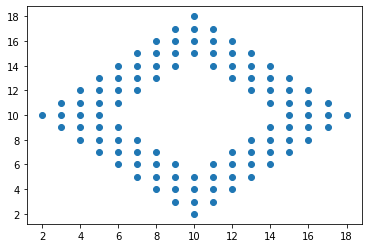

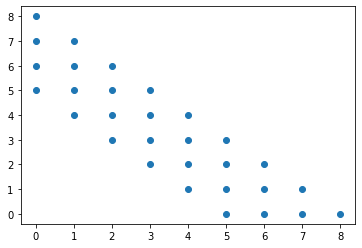

In [53]:
def donut_neighbours(center, distance, shape):
    # finds all neighbours within r and 2r of center
    outer = set(zip(*neighbours_within(center, 2*distance, shape)))
    inner = set(zip(*neighbours_within(center, distance, shape)))
    y, x = zip(*list(outer - inner))
    return y, x
    
y, x = donut_neighbours((10, 10), 4, (20, 20))
plt.scatter(x, y)
plt.show()

y, x = donut_neighbours((0, 0), 4, (20, 20))
plt.scatter(x, y)
plt.show()

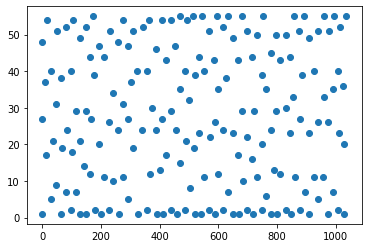

In [68]:
def find_peaks_spaced(arr, distance):
    """ Ugly function that finds the points in a spectrogram with maximum power
        such that no two points are closer than `distance` together.
    """
    # so we can remove peaks from consideration
    temp_arr = arr.copy()
    peaks = []
    initial_neighbours = neighbours_within((0,0), distance, arr.shape)
    powers = temp_arr[initial_neighbours]
    max_power = np.argmax(powers)
    peak = initial_neighbours[0][max_power], initial_neighbours[1][max_power]
    peaks.append(peak)
    temp_arr[peak] = -np.inf
    temp_arr[initial_neighbours] = -np.inf
    new_peaks_found = True
    while new_peaks_found:
        new_peaks_found = False
        for peak in peaks:
            neighbours = donut_neighbours(peak, distance, arr.shape)
            powers = temp_arr[neighbours]
            max_power = np.argmax(powers)
            peak_candidate = neighbours[0][max_power], neighbours[1][max_power]
            for peak in peaks:
                if abs(peak_candidate[0] - peak[0]) + abs(peak_candidate[1] - peak[1]) < distance:
                    break
            else:
                peaks.append(peak_candidate)
                # don't look at neighbours of peak again
                neighbours = neighbours_within(peak_candidate, distance, arr.shape)
                temp_arr[neighbours] = -np.inf
                new_peaks_found = True
            # make sure we don't look at this peak again
            temp_arr[peak_candidate] = -np.inf
#         plt.pcolormesh(t, f, temp_arr)
#         plt.show()
    return peaks

peaks = find_peaks_spaced(Sxx, 20)
y, x = zip(*peaks)
plt.scatter(x, y)
plt.show()

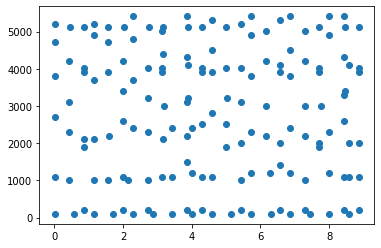

In [66]:
# just to remember what the old one looked like
plt.scatter(peaks_x, peaks_y)
plt.show()